In [29]:
import os
import torch
from torch.fft import fft, ifft
import numpy as np
import functools
import matplotlib.pyplot as plt
from torchtyping import TensorType
from scorematching.signalsamplers import circulant
from scorematching.utils import Langevin_sampler, align
from scorematching.models.scoremodels import ConvScoreModel
from scorematching.signalsamplers import GaussianSampler
from score_projection import score_projector
from pwrspec_score import pwrspec_score
from triple_corr_score import triple_corr_score_3, compute_triple_corr

In [ ]:
class GaussianScoreModel(torch.nn.Module):
    def __init__(
        self, 
        mean: TensorType["L"],
        covar_mat: TensorType["L", "L"], 
        circulate=False,
    ):
        super().__init__()

        assert torch.allclose(covar_mat, covar_mat.T), "The covariance matrix must be symmetric."

        self.register_buffer(
            "prec_mat",
            torch.inverse(covar_mat),
        )
        self.register_buffer(
            "mean",
            mean,
        )
        self.register_buffer(
            "mean_circulant",
            circulant(mean, dim=0),
        )
        self.circulate = circulate
    
    def forward(
        self, 
        x: TensorType["B", "L"],
    ) -> TensorType["B", "L"]:
        if self.circulate:
            closest_idx = (x.unsqueeze(1) - self.mean_circulant).square().sum(dim=2).sqrt().min(dim=1)[1]
            res = torch.einsum(
                'ij, ...j -> ...i', 
                self.prec_mat, 
                self.mean_circulant[closest_idx, :] - x,
            )
        else:
            res = torch.einsum(
                'ij, ...j -> ...i', 
                self.prec_mat, 
                self.mean - x,
            )
        return res
    

In [31]:
### Set pytorch parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f"Current device is \'{device}\'.")

Current device is 'cuda'.


In [32]:
### Set parameters for MRA
M = 1000000
sigma = 5.

In [33]:
### Set parameters for true signal
length = 3
signal_true = torch.zeros((length,), device=device, requires_grad=False)
signal_true[0] += np.sqrt(length)
# signal_true += 1.
# signal_true += 0.001 * torch.randn_like(signal_true)

In [34]:
### Set parameters for conditioner
conditioner_type = "triple correlation" # "power spectrum", "triple_correlation"
use_random_statistics = True
use_CLT = True
use_none_cond = False

In [35]:
### Set parameters for score model
scoremodel_type = "gaussian" # "gaussian", "learned", "none"

In [36]:
### Set parameters for gaussian score model
use_circulate = True # If True, the distribution is piecewise gaussian.
prior_mean = signal_true
prior_A = 0.5 * torch.eye(n=length, device=device)
# prior_mean = torch.tensor([1., 0., 0.], device=device)
# prior_A = 0.1*torch.tensor([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]], device=device)

In [37]:
### Set parameters for learned score model
PATH = None # If None it will try to find a compatible model.
hiddendim = 8

In [38]:
### Set parameters for Langevin sampling
num_steps = 200000
num_samples = 2 ** 10
eps = 5e-6

In [40]:
#### Conditioner setup.
circulant_true = circulant(signal_true, dim=0)
power_spectrum_true = torch.abs(fft(signal_true, norm='ortho')).square()

if not use_none_cond:
    MRA_sampler = GaussianSampler(
        sigma=sigma, 
        signal=signal_true, 
        length=length, 
        device=device,
    )
    MRA_samples = MRA_sampler(num=M, do_random_shifts=True)
    if use_random_statistics:
        sample_power_spectrum = torch.abs(fft(MRA_samples, norm='ortho')).square().mean(dim=0)
        if length == 3:
            sample_triple_corr = compute_triple_corr(MRA_samples, average=True, device=device)
            # print(sample_triple_corr)
    else:
        sample_power_spectrum = power_spectrum_true + sigma ** 2
        if length == 3:
            triple_corr_true = compute_triple_corr(signal_true, device=device)
            sample_triple_corr = torch.zeros(size=(3, 3), device=device)
            sample_triple_corr[0, 0] += 1.
            sample_triple_corr[0, :] += 1.
            sample_triple_corr[:, 0] += 1.
            sample_triple_corr[1, 2] += 1.
            sample_triple_corr[2, 1] += 1.
            sample_triple_corr *= sigma ** 2 * torch.mean(signal_true)
            sample_triple_corr += triple_corr_true

if use_none_cond:
    conditioner = None
    conditioner_type = "no conditioner"
elif conditioner_type == "power spectrum":
    conditioner = functools.partial(
        pwrspec_score,
        rho=sample_power_spectrum,
        M=M,
        sigma=sigma,
        device=device,
        CLT=use_CLT,
    )
elif conditioner_type == "triple correlation":
    if length == 3:
        conditioner = functools.partial(
            triple_corr_score_3,
            triple_corr=sample_triple_corr,
            M=M,
            sigma=sigma,
            device=device,
            CLT=use_CLT,
        )
    else:
        raise NotImplementedError
else:
    raise NotImplementedError

In [41]:
#### Score model setup.
if scoremodel_type == "gaussian":
    covar_mat = torch.einsum('ij, kj -> ik', prior_A, prior_A)
    scoremodel = GaussianScoreModel(prior_mean, covar_mat, use_circulate).to(device)
elif scoremodel_type == "learned":
    if PATH is None:
        PATH = f"./../model_weights/scorematching/MRA_convscoremodel_length{length}_hiddim{hiddendim}/"
        PATH = os.path.join(PATH, "weights_dict.pth")
    if not os.path.exists(PATH):
        raise ValueError(f"Could not find {PATH = }")
    scoremodel = ConvScoreModel(length=length, hiddendim=hiddendim).to(device)
    state_dict = torch.load(PATH, weights_only=True, map_location=device)
    scoremodel.load_state_dict(state_dict)
    scoremodel.eval()
elif scoremodel_type == "none":
    scoremodel = None
else:
    raise ValueError("Unimplemented scoremodel_type")

In [42]:
#### Generate input samples
input = torch.norm(signal_true) * torch.randn(
    size=(num_samples, signal_true.shape[-1]), 
    device=device,
    requires_grad=False,
)
# input = torch.einsum('ij, ...j -> ...i', prior_A, input)
# input += prior_mean

# input_sampler = GaussianSampler(
#     sigma=0.1, 
#     signal=signal_true, 
#     length=length, 
#     device=device,
# )
# input = input_sampler(num=num_samples, do_random_shifts=True)

In [ ]:
#### Run Langevin sampling
output = Langevin_sampler(
    input=input,
    scoremodel=scoremodel,
    conditioner=conditioner,
    num_steps=num_steps,
    eps=eps,
    device=device,
)

if torch.any(torch.isfinite(output.reshape((-1))).logical_not()):
    print("Some of the output is nan or inf.")
else:
    print("Successful sample generation.")

In [ ]:
#### Compute and print comparison of input and output

### Mean RMSD to true power spectrum.
input_power_spectra = torch.abs(fft(input, norm='ortho')).square()
output_power_spectra = torch.abs(fft(output, norm='ortho')).square()
inputs_power_spectra_rmsd = (
    input_power_spectra - power_spectrum_true
).square().mean(dim=1).sqrt()
outputs_power_spectra_rmsd = (
    output_power_spectra - power_spectrum_true
).square().mean(dim=1).sqrt()

print(
    " Average RMSD between input power spectra and the true power spectrum is:  ", 
    f"{inputs_power_spectra_rmsd.mean().item():.2f}\n",
    "Average RMSD between output power spectra and the true power spectrum is: ", 
    f"{outputs_power_spectra_rmsd.mean().item():.2f}"
)

### Mean generalized RMSD to true signal.
inputs_rmsd = (input.unsqueeze(1) - circulant_true.unsqueeze(0)).square().mean(dim=2).sqrt().min(dim=1)[0]
outputs_rmsd = (output.unsqueeze(1) - circulant_true.unsqueeze(0)).square().mean(dim=2).sqrt().min(dim=1)[0]

print(
    " Average RMSD between input samples and the true signal is:  ", 
    f"{inputs_rmsd.mean().item():.2f}\n",
    "Average RMSD between output samples and the true signal is: ", 
    f"{outputs_rmsd.mean().item():.2f}",
)

### Find the output sample that minimizes generalized RMSD.
# output_circulant = circulant(output, dim=-1)
# best_output_idx = (
#     output.unsqueeze(0).unsqueeze(2) - output_circulant.unsqueeze(1)
# ).square().sum(dim=3).min(dim=2)[0].sum(dim=1).min(dim=0)[1]
# best_output = output[best_output_idx, :]

# print(
#     " The best output sample centroid wrt RMSD is: (", 
#     ", ".join([f"{x.item():5.2f}" for x in best_output]),
#     ")\n",
#     "For reference, the aligned true signal is:   (",
#     ", ".join([f"{x.item():5.2f}" for x in align(signal_true, best_output)]),
#     ")",
# )
# aligned_output_est = align(output, best_output)

aligned_output = align(output, signal_true)

 Average RMSD between input power spectra and the true power spectrum is:   2.73
 Average RMSD between output power spectra and the true power spectrum is:  0.04
 Average RMSD between input samples and the true signal is:   1.34
 Average RMSD between output samples and the true signal is:  0.11


In [ ]:
#### Prepare to plot results
input = input.detach().to('cpu')
output = output.detach().to('cpu')
signal_true = signal_true.detach().to('cpu')
circulant_true = circulant_true.detach().to('cpu')
power_spectrum_true = power_spectrum_true.detach().to('cpu')
# best_output = best_output.detach().to('cpu')
aligned_output = aligned_output.detach().to('cpu')
output_power_spectra = output_power_spectra.detach().to('cpu')
if not use_none_cond:
    MRA_samples = MRA_samples.detach().to('cpu')

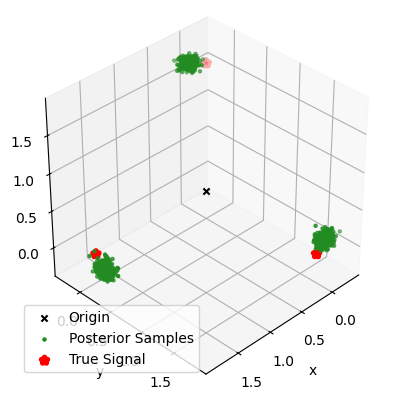

In [49]:
### Scatter plot of input/output samples in 3D
plot_output_only = False
plot_input = False

if signal_true.shape[0] == 3:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        [0.],
        [0.],
        [0.],
        c='black',
        marker = 'x',
    )
    ax.scatter(
        output[:, 0], 
        output[:, 1], 
        output[:, 2], 
        c='forestgreen',
        marker='.',
    )
    if use_none_cond:
        output_samples_tag = "Prior Samples"
    else:
        output_samples_tag = "Posterior Samples"
    if not plot_output_only:
        if plot_input:
            ax.scatter(
                input[:, 0], 
                input[:, 1], 
                input[:, 2], 
                c='cornflowerblue',
                marker='.',
            )
        if signal_true.shape[0] == 3:
            ax.scatter(
                circulant_true[0:3, 0], 
                circulant_true[0:3, 1], 
                circulant_true[0:3, 2], 
                c='red',
                marker='*',
                linewidth=4.,
            )
            if conditioner_type == "power spectrum":
                theta = np.linspace(0, 2 * np.pi, 100)
                radius = torch.norm(signal_true - signal_true.mean()).item()
                phi = -np.pi/4
                xyz = np.stack(
                    [
                        radius * np.sin(theta) * np.cos(phi),
                        radius * np.sin(theta) * np.sin(phi),
                        radius * np.cos(theta),
                    ],
                    axis=0,
                ) # Start with a circle around the x-axis (theta), rotate to circle around [1, 1, 0] (phi).
                rotmat = np.array(
                    [
                        [0.9082704, -0.0917296, -0.4082040],
                        [-0.0917296, 0.9082704, -0.4082040],
                        [0.4082040, 0.4082040, 0.8165408],
                    ]
                ) # Rotation by 35.26 degrees to go from circle around [1, 1, 0] to circle around [1, 1, 1].
                xyz = rotmat @ xyz
                xyz1 = xyz + signal_true[0:3].mean().item()
                xyz2 = xyz - signal_true[0:3].mean().item()
                ax.plot(xyz1[0, ...], xyz1[1, ...], xyz1[2, ...], c='red', linestyle='dotted', linewidth=1.5)
                ax.plot(xyz2[0, ...], xyz2[1, ...], xyz2[2, ...], c='red', linestyle='dotted', linewidth=1.5)
                if plot_input:
                    ax.legend(["Origin", output_samples_tag, "Gaussian Samples", "True Signal", "Phase Manifold"])  
                else:
                    ax.legend(["Origin", output_samples_tag, "True Signal", "Phase Manifold"])  
            if plot_input:
                ax.legend(["Origin", output_samples_tag, "Gaussian Samples", "True Signal"])  
            else:
                ax.legend(["Origin", output_samples_tag, "True Signal"])  
        else:
            if plot_input:
                ax.legend(["Origin", output_samples_tag, "Gaussian Samples"])
            else:
                ax.legend(["Origin", output_samples_tag])
    else:
        ax.legend(["Origin", output_samples_tag])

    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.view_init(elev=35, azim=-45, roll=0)

    plt.savefig(f"./../figs/scorematching/{conditioner_type}/fig1.png")
    plt.savefig(f"./../figs/scorematching/{conditioner_type}/fig1.svg")

    ax.view_init(elev=35, azim=45, roll=0)

    plt.savefig(f"./../figs/scorematching/{conditioner_type}/fig2.png")
    plt.savefig(f"./../figs/scorematching/{conditioner_type}/fig2.svg")

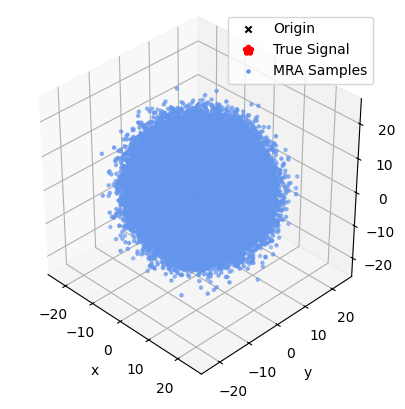

In [50]:
### Scatter plot of MRA samples in 3D

if signal_true.shape[0] == 3:
    figmra = plt.figure()
    axmra = figmra.add_subplot(projection='3d')
    axmra.scatter(
        [0.],
        [0.],
        [0.],
        c='black',
        marker = 'x',
    )
    axmra.scatter(
        circulant_true[0:3, 0], 
        circulant_true[0:3, 1], 
        circulant_true[0:3, 2], 
        c='red',
        marker='*',
        linewidth=4.,
    )
    axmra.scatter(
        MRA_samples[:, 0], 
        MRA_samples[:, 1], 
        MRA_samples[:, 2], 
        c='cornflowerblue',
        marker='.',
    )
    axmra.legend(["Origin", "True Signal", "MRA Samples"])  
    axmra.set_aspect('equal')
    axmra.set_xlabel("x")
    axmra.set_ylabel("y")
    axmra.set_zlabel("z")

    axmra.view_init(elev=35, azim=-45, roll=0)

    plt.savefig(f"./../figs/scorematching/{conditioner_type}/MRA_samples.svg")
    plt.savefig(f"./../figs/scorematching/{conditioner_type}/MRA_samples.png")

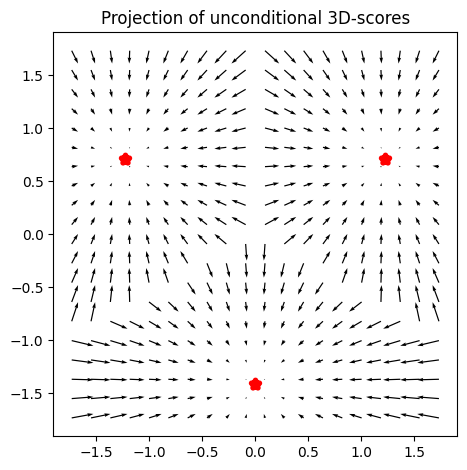

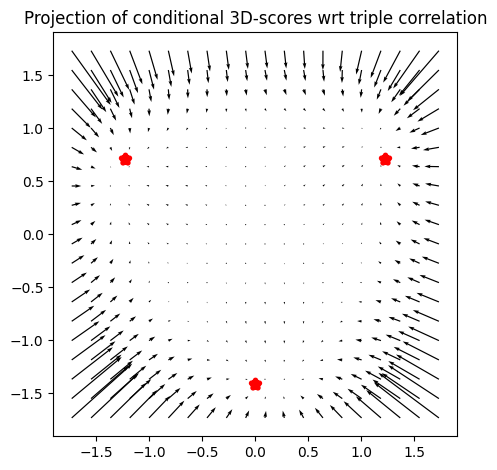

In [58]:
### Plot projection of 3D scores onto plane with true signal.

### Set parameters for visualization of scores
ax_bound = torch.norm(signal_true)
ax_pts = 20
plane_mag = signal_true.mean().item()

if signal_true.shape[0] == 3:
    if not scoremodel is None:
        S1, XY1, P1 = score_projector(
            t_diff=0,
            scoremodel=scoremodel, 
            conditioner=None,
            plane_mag=plane_mag, 
            ax_bound=ax_bound,
            ax_pts=ax_pts,
            device=device,
        )
        XY1 = XY1.to('cpu')
        S1 = S1.to('cpu')

        fig1, ax1 = plt.subplots()
        Q1 = ax1.quiver(
            XY1[:, :, 0], 
            XY1[:, :, 1], 
            S1[:, :, 0], 
            S1[:, :, 1],
        )
        ax1.set_aspect('equal', 'box')
        centers = plt.scatter(
            (P1.to('cpu') @ circulant(signal_true[:3], 0))[0, :], 
            (P1.to('cpu') @ circulant(signal_true[:3], 0))[1, :],
            c='red',
            marker='*',
            linewidth=4.,
        ) 

        plt.title(f"Projection of unconditional 3D-scores")
        fig1.tight_layout()
        plt.savefig(f'./../figs/scorematching/{conditioner_type}/unconditionalscores.png')

    if not use_none_cond:
        S2, XY2, P2 = score_projector(
            t_diff=0,
            scoremodel=scoremodel, 
            conditioner=conditioner,
            plane_mag=plane_mag, 
            ax_bound=ax_bound,
            ax_pts=ax_pts,
            device=device,
        )
        XY2 = XY2.to('cpu')
        S2 = S2.to('cpu')

        fig2, ax2 = plt.subplots()

        Q2 = ax2.quiver(
            XY2[:, :, 0], 
            XY2[:, :, 1], 
            S2[:, :, 0], 
            S2[:, :, 1],
        )
        ax2.set_aspect('equal', 'box')
        centers = plt.scatter(
            (P2.to('cpu') @ circulant(signal_true[:3], 0))[0, :], 
            (P2.to('cpu') @ circulant(signal_true[:3], 0))[1, :],
            c='red',
            marker='*',
            linewidth=4.,
        ) 

        plt.title(f"Projection of conditional 3D-scores wrt {conditioner_type}")
        fig2.tight_layout()
        plt.savefig(f'./../figs/scorematching/{conditioner_type}/conditionalscores.png')

In [ ]:
### Histogram plot over signals in 1D

if signal_true.shape[0] == 1:
    fig, ax = plt.subplots(1, 2, sharey=True, tight_layout=True)
    ax[0].hist(input)
    ax[1].hist(output)
    ax[0].plot(signal_true, 0*signal_true, 'd')
    ax[1].plot(signal_true, 0*signal_true, 'd')

NameError: name 'aligned_output' is not defined

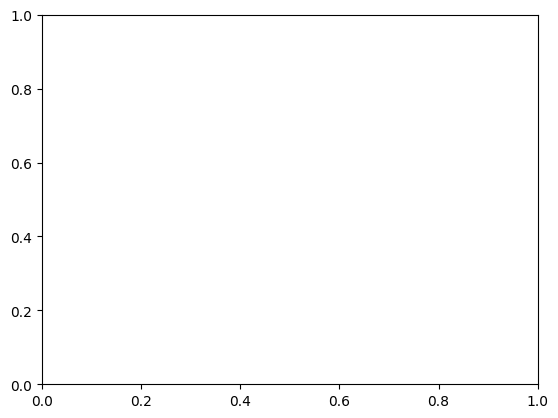

In [59]:
### Violin plots of output samples

if signal_true.shape[0] >= 3:
    fig2, ax2 = plt.subplots()
    vp2 = ax2.violinplot(
        aligned_output, 
        positions=range(length), 
        showmeans=True,
        # showmedians=True,
        # label="Median Output Sample",
    )
    vp2['cmeans'].set_color('black') 
    vp2['cbars'].set_color('green') 
    vp2['cmins'].set_color('green') 
    vp2['cmaxes'].set_color('green') 
    for body in vp2['bodies']:
        body.set_facecolor('lightgreen')
        body.set_edgecolor('green')
    ax2.scatter(
        range(length), 
        signal_true, 
        c='r', 
        marker='_', 
        linewidth=2., 
        label="True Signal",
    )
    ax2.legend()
    ax2.xaxis.set_ticklabels([])
    if use_none_cond:
        plt.title("Violin plot of prior samples aligned with true signal.")
        plt.savefig(f'./../figs/scorematching/{conditioner_type}/violinplot_samples_{length=}.png')
    else:
        if use_random_statistics:
            plt.title(f"Violin plot of posterior samples wrt mean {conditioner_type}.")
            plt.savefig(f'./../figs/scorematching/{conditioner_type}/violinplot_samples_{length=}_poppwrspec.png')
        else:
            plt.title(f"Violin plot of posterior samples wrt true {conditioner_type}.")
            plt.savefig(f'./../figs/scorematching/{conditioner_type}/violinplot_samples_{length=}_truepwrspec.png')
    
    fig3, ax3 = plt.subplots()
    vp3 = ax3.violinplot(
        output_power_spectra[:, :(length+1)//2], 
        positions=range((length+1)//2), 
        showmeans=True,
        # showmedians=True,
        # label="Median Power Spectrum",
    )
    vp3['cmeans'].set_color('black') 
    vp3['cbars'].set_color('green') 
    vp3['cmins'].set_color('green') 
    vp3['cmaxes'].set_color('green') 
    for body in vp3['bodies']:
        body.set_facecolor('lightgreen')
        body.set_edgecolor('green')
    ax3.scatter(
        range((length+1)//2), 
        power_spectrum_true[:(length+1)//2], 
        c='r', 
        marker='_', 
        linewidth=2., 
        label="True Power Spectrum",
    )
    ax3.legend()
    if use_none_cond:
        plt.title("Violin plot of prior sample power spectra.")
        plt.savefig(f'./../figs/scorematching/{conditioner_type}/violinplot_pwrspec_{length=}.png')
    else:
        if use_random_statistics:
            plt.title(f"Violin plot of posterior sample power spectra wrt mean {conditioner_type}.")
            plt.savefig(f'./../figs/scorematching/{conditioner_type}/violinplot_pwrspec_{length=}_poppwrspec.png')
        else:
            plt.title(f"Violin plot of posterior sample power spectra wrt true {conditioner_type}.")
            plt.savefig(f'./../figs/scorematching/{conditioner_type}/violinplot_pwrspec_{length=}_truepwrspec.png')